## Importing libraries and Installing packages


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import seaborn as sn

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading dataset

In [ ]:
sexism_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Files/440Project/train_all_tasks.csv")
print("Shape of training data = ", sexism_dataset.shape)
sexism_dataset.sample(10)

Shape of training data =  (14000, 5)


,rewire_id,text,label_sexist,label_category,label_vector
6707,sexism2022_english-19007,For real dude they’re all such angry little cu...,not sexist,none,none
1537,sexism2022_english-11577,He might leave yes but he might not. The woman...,not sexist,none,none
1054,sexism2022_english-12492,This is what ordination of women leads to. [URL],not sexist,none,none
5598,sexism2022_english-4064,Unattractive women don't get bred out and pass...,sexist,2. derogation,2.1 descriptive attacks
335,sexism2022_english-15946,My daughter just took 2 black guys up to her b...,not sexist,none,none
5197,sexism2022_english-12135,So glad to be alive and chasing a dream. Thank...,not sexist,none,none
9411,sexism2022_english-6404,How did the paid to act deranged people who sh...,not sexist,none,none
5738,sexism2022_english-11785,"He definitely is, he doesn’t worship the death...",not sexist,none,none
5836,sexism2022_english-746,Barely talk is indication of low interest. #ne...,sexist,2. derogation,2.1 descriptive attacks
6903,sexism2022_english-12649,This is the real answer lol. And it says a lot...,not sexist,none,none


In [ ]:
# Checking for missing values

sexism_dataset.isnull().values.any()

False

<Axes: xlabel='label_sexist', ylabel='count'>

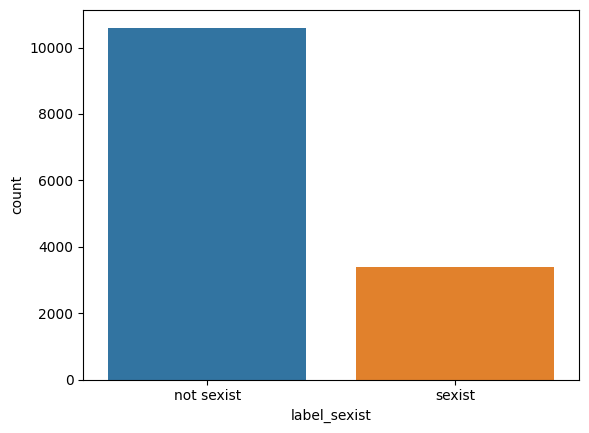

In [ ]:
# Observing class balance

import seaborn as sns
sns.countplot(x='label_sexist', data=sexism_dataset)

## Data Preprocessing

In [ ]:
# Dropping all columns except text and label_sexist

sexism_dataset=sexism_dataset.drop(['rewire_id','label_category', 'label_vector'], axis=1)
sexism_dataset.sample(10)

,text,label_sexist
1993,"For a while, I thought the same thing. Then he...",not sexist
11593,Fuck a woman with a dick you hateful piece of ...,sexist
7132,"Hmm, yes, your logic is quite sound. I mean, w...",not sexist
11831,No female wants this. They may say/think they ...,sexist
12977,She can go back to her own country. She'd go t...,not sexist
1002,We may shit on women but no one here on MGTOW ...,not sexist
6488,I think feminism is just female nature on a so...,sexist
2638,"Wife? don't you mean husband, unless, unless s...",not sexist
4597,I always pirate movies but waiting for months ...,not sexist
2287,I have had a ex-girlfriend file a false rape c...,sexist


In [ ]:
# Cleaning the data and remmoving unnecessary stuff

def preprocess_text(sen):

    # Lowercasing sentence
    sentence = sen.lower()

    # Removing html tags
    TAG_RE = re.compile(r'<[^>]+>')
    sentence = TAG_RE.sub('', sentence)

    # Removing punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Removing single character
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Removing Stopwords
    # pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    # sentence = pattern.sub('', sentence)

    return sentence

sexism_dataset['cleaned_text'] = sexism_dataset['text'].apply(preprocess_text)
sexism_dataset.sample(10)

,text,label_sexist,cleaned_text
9569,"At $1,000 USD per introduction, it's 3-D prost...",not sexist,at usd per introduction it d prostitution wher...
6066,"I have been, but my plan has always been to wa...",not sexist,i have been but my plan has always been to wai...
5139,Think of her sucking another dudes dick. Then ...,not sexist,think of her sucking another dudes dick then i...
7709,"yep it is,i dont like my crush anymore after i...",sexist,yep it is dont like my crush anymore after ve ...
13495,No ;) she isn't LOLZY,not sexist,no she isn lolzy
9606,nothing irks a left wing feminist worse than s...,sexist,nothing irks left wing feminist worse than see...
1889,She has a link on her twitter for people to se...,sexist,she has link on her twitter for people to send...
5288,Hahah! If you intentionally made her family ha...,not sexist,hahah if you intentionally made her family hat...
12100,[USER] Nothing ever comes before personal inte...,not sexist,user nothing ever comes before personal inter...
4081,Won't miss her liberal wrinkly ass! Bye bitch,sexist,won miss her liberal wrinkly ass bye bitch


In [ ]:
# Label Binarization -> sexist=1, not sexist=0

sexism_dataset['binary_label_sexist']=sexism_dataset['label_sexist'].apply(lambda x: 1 if x=='sexist' else 0)
sexism_dataset.sample(10)

,text,label_sexist,cleaned_text,binary_label_sexist
10622,Seriously! I can see why she cried -- he basic...,not sexist,seriously can see why she cried he basically t...,0
8543,Just because she paid doesn't mean he owes her...,not sexist,just because she paid doesn mean he owes her a...,0
5646,I believe one of the comments to the article p...,not sexist,i believe one of the comments to the article p...,0
3287,Any man who takes her deserves her and deserve...,not sexist,any man who takes her deserves her and deserve...,0
2943,Don't mess with granny!,not sexist,don mess with granny,0
5740,“No one need be surprised if among our people ...,not sexist,no one need be surprised if among our people ...,0
6245,"Wear your better clothes, but change it up wit...",not sexist,wear your better clothes but change it up with...,0
8732,Depends on a lot of things. If you're young an...,not sexist,depends on lot of things if you re young and y...,0
1664,Not sure she ever had a brain...,sexist,not sure she ever had brain,1
370,Indeed they do. Personally I'm more of a dog p...,not sexist,indeed they do personally m more of dog person...,0


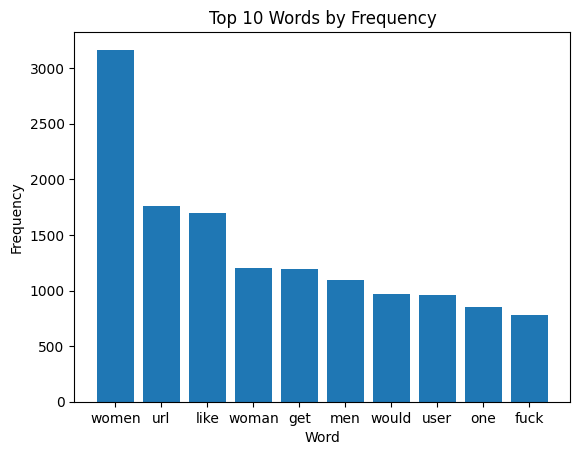

In [ ]:
#Word Frequency Analysis

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sexism_dataset['cleaned_text'])
word_counts = tokenizer.word_counts

# Remove stop words
stop_words = set(stopwords.words('english'))
word_counts = {word: count for word, count in word_counts.items() if word not in stop_words}

# Sort the words by frequency
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the top words and their frequencies
top_words = sorted_words[:10]
word_labels = [word[0] for word in top_words]
word_freqs = [word[1] for word in top_words]

# Visualize the results
plt.bar(word_labels, word_freqs)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 10 Words by Frequency')
plt.show()

In [ ]:
# Splitting our dataset into train(70%), val(15%) and test(15%)

X_trainval, X_test, y_trainval, y_test = train_test_split(sexism_dataset['cleaned_text'], sexism_dataset['binary_label_sexist'], test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.176, random_state=42)

In [ ]:
# Calculate the proportions of each set

train_prop = len(X_train) / len(sexism_dataset['cleaned_text'])
val_prop = len(X_val) / len(sexism_dataset['cleaned_text'])
test_prop = len(X_test) / len(sexism_dataset['cleaned_text'])

# Print the proportions
print("Training set proportion: {:.2f}".format(train_prop))
print("Validation set proportion: {:.2f}".format(val_prop))
print("Test set proportion: {:.2f}".format(test_prop))

Training set proportion: 0.70
Validation set proportion: 0.15
Test set proportion: 0.15


## Preparing embedding layer

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length  #number of unique words

17093

In [ ]:
# Padding all comment sentences to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Colab Notebooks/Files/440Project/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all unique words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

##Training with CNN

In [ ]:
from keras.layers import Conv1D
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

In [ ]:
# Defining Model Architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model Compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1709300   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,773,557
Trainable params: 64,257
Non-trainable params: 1,709,300
_________________________________________________________________
None


In [ ]:
# Model Training

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
cnn_model_history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
154/154 [==============================] - 19s 96ms/step - loss: 0.5082 - acc: 0.7698 - val_loss: 0.4880 - val_acc: 0.7704
Epoch 2/20
154/154 [==============================] - 8s 49ms/step - loss: 0.3985 - acc: 0.8275 - val_loss: 0.4342 - val_acc: 0.8124
Epoch 3/20
154/154 [==============================] - 10s 64ms/step - loss: 0.3400 - acc: 0.8587 - val_loss: 0.4216 - val_acc: 0.8220
Epoch 4/20
154/154 [==============================] - 8s 53ms/step - loss: 0.2915 - acc: 0.8845 - val_loss: 0.4151 - val_acc: 0.8277
Epoch 5/20
154/154 [==============================] - 9s 60ms/step - loss: 0.2361 - acc: 0.9189 - val_loss: 0.4445 - val_acc: 0.8248
Epoch 6/20
154/154 [==============================] - 10s 65ms/step - loss: 0.1902 - acc: 0.9436 - val_loss: 0.4383 - val_acc: 0.8267
Epoch 7/20
154/154 [==============================] - 8s 49ms/step - loss: 0.1519 - acc: 0.9626 - val_loss: 0.4429 - val_acc: 0.8243


In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

66/66 [==============================] - 1s 11ms/step - loss: 0.4241 - acc: 0.8205


66/66 [==============================] - 1s 17ms/step


Text(50.722222222222214, 0.5, 'Truth')

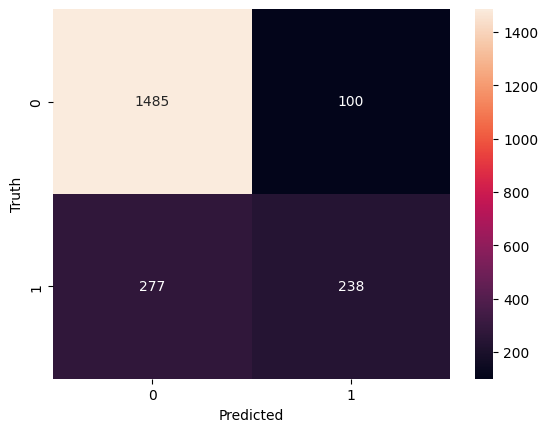

In [ ]:
# Model Performance

from sklearn.metrics import confusion_matrix, classification_report
import sys
import numpy as np

np.set_printoptions(threshold=sys.maxsize)
y_pred = cnn_model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

cm=confusion_matrix(y_test,y_pred)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [ ]:
,print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1585
           1       0.70      0.46      0.56       515

    accuracy                           0.82      2100
   macro avg       0.77      0.70      0.72      2100
weighted avg       0.81      0.82      0.81      2100



## Training with Bidirectional LSTM


In [ ]:
from keras.layers import LSTM
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

In [ ]:
# Defining Model Architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(Bidirectional(LSTM(128,activation='relu')))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model Compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1709300   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,944,053
Trainable params: 234,753
Non-trainable params: 1,709,300
_________________________________________________________________
None


In [ ]:
# Model Training

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
lstm_model_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
154/154 [==============================] - 90s 562ms/step - loss: 1.1762 - acc: 0.7523 - val_loss: 0.5149 - val_acc: 0.7575
Epoch 2/20
154/154 [==============================] - 70s 456ms/step - loss: 0.9199 - acc: 0.7886 - val_loss: 0.4608 - val_acc: 0.8010
Epoch 3/20
154/154 [==============================] - 72s 470ms/step - loss: 0.4234 - acc: 0.8192 - val_loss: 0.4357 - val_acc: 0.8143
Epoch 4/20
154/154 [==============================] - 76s 495ms/step - loss: 0.3946 - acc: 0.8314 - val_loss: 0.4040 - val_acc: 0.8282
Epoch 5/20
154/154 [==============================] - 76s 494ms/step - loss: 0.3754 - acc: 0.8411 - val_loss: 0.4088 - val_acc: 0.8358
Epoch 6/20
154/154 [==============================] - 78s 504ms/step - loss: 0.3561 - acc: 0.8475 - val_loss: 0.3924 - val_acc: 0.8344
Epoch 7/20
154/154 [==============================] - 75s 489ms/step - loss: 0.4601 - acc: 0.8207 - val_loss: 0.4371 - val_acc: 0.8048
Epoch 8/20
154/154 [==============================] - 7

In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

66/66 [==============================] - 6s 87ms/step - loss: 0.4088 - acc: 0.8143


66/66 [==============================] - 7s 108ms/step


Text(50.722222222222214, 0.5, 'Truth')

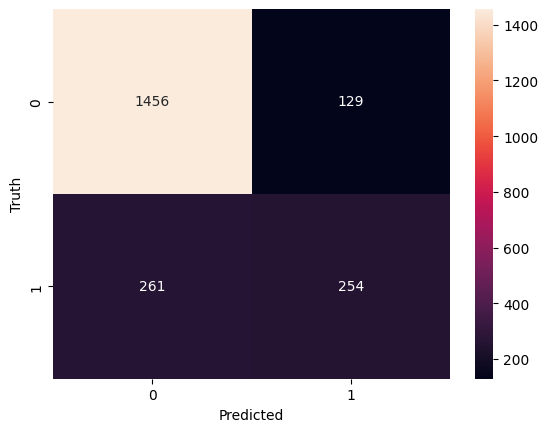

In [ ]:
# Model Performance

from sklearn.metrics import confusion_matrix, classification_report
import sys
import numpy as np

np.set_printoptions(threshold=sys.maxsize)
y_pred = lstm_model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

cm=confusion_matrix(y_test,y_pred)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1585
           1       0.66      0.49      0.57       515

    accuracy                           0.81      2100
   macro avg       0.76      0.71      0.72      2100
weighted avg       0.80      0.81      0.80      2100



## Training with GRU

In [ ]:
from keras.layers import GRU

In [ ]:
# Defining Model Architecture

gru_model = Sequential()
gru_model.add(Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))
gru_model.add(GRU(256, activation='relu')),
gru_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model Compiling

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(gru_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1709300   
                                                                 
 gru_1 (GRU)                 (None, 256)               274944    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,984,501
Trainable params: 275,201
Non-trainable params: 1,709,300
_________________________________________________________________
None


In [ ]:
# Model Training

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
gru_model_history = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
154/154 [==============================] - 67s 424ms/step - loss: 0.6386 - acc: 0.7582 - val_loss: 0.5566 - val_acc: 0.7556
Epoch 2/20
154/154 [==============================] - 70s 452ms/step - loss: 0.5536 - acc: 0.7582 - val_loss: 0.5562 - val_acc: 0.7556
Epoch 3/20
154/154 [==============================] - 63s 408ms/step - loss: 0.5504 - acc: 0.7582 - val_loss: 0.5498 - val_acc: 0.7556
Epoch 4/20
154/154 [==============================] - 70s 456ms/step - loss: 0.5436 - acc: 0.7582 - val_loss: 0.5476 - val_acc: 0.7556
Epoch 5/20
154/154 [==============================] - 65s 424ms/step - loss: 0.5229 - acc: 0.7588 - val_loss: 0.4958 - val_acc: 0.7785
Epoch 6/20
154/154 [==============================] - 69s 445ms/step - loss: 0.4288 - acc: 0.8145 - val_loss: 0.4231 - val_acc: 0.8210
Epoch 7/20
154/154 [==============================] - 64s 415ms/step - loss: 0.4042 - acc: 0.8277 - val_loss: 0.4194 - val_acc: 0.8282
Epoch 8/20
154/154 [==============================] - 6

In [ ]:
# Predictions on the Test Set

score = gru_model.evaluate(X_test, y_test, verbose=1)

66/66 [==============================] - 6s 94ms/step - loss: 0.4112 - acc: 0.8252


66/66 [==============================] - 7s 103ms/step


Text(50.722222222222214, 0.5, 'Truth')

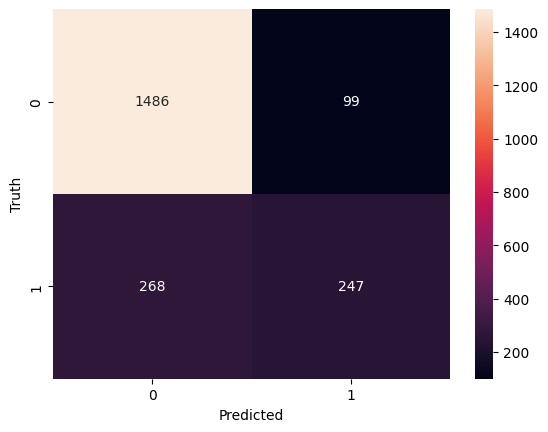

In [ ]:
# Model Performance

from sklearn.metrics import confusion_matrix, classification_report
import sys
import numpy as np

np.set_printoptions(threshold=sys.maxsize)
y_pred = gru_model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

cm=confusion_matrix(y_test,y_pred)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1585
           1       0.71      0.48      0.57       515

    accuracy                           0.83      2100
   macro avg       0.78      0.71      0.73      2100
weighted avg       0.81      0.83      0.81      2100

